#Get The Data

In [1]:
# Import needed libraries
# from google.colab import files
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast

In [2]:
#This for google colab only 
# uploaded = files.upload()

In [3]:
#Load the dataset
movies = pd.read_csv("movies_metadata.csv", low_memory=False)
credits = pd.read_csv("credits.csv")

#Extract The Data To Be Used

In [4]:
#Extract genre column from the movies
#helper function that extract the genre and return in as a json format

def get_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        return [g['name'] for g in genres_list]
    except:
        return []

# Get genres list for each movie
movies['genres_list'] = movies['genres'].apply(get_genres)



In [5]:
#Extract the Directors name

def get_directors(crew_str):
    try:
        crew_list = ast.literal_eval(crew_str)
        return [member['name'] for member in crew_list if member['job'] == 'Director']
    except:
        return []

credits['director_list'] = credits['crew'].apply(get_directors)



In [6]:
# Merge movies & credits (like sql join)
movies['id'] = movies['id'].astype(str)
credits['id'] = credits['id'].astype(str)

movie_data = pd.merge(movies, credits, on='id')

#Define The Dataset

In [7]:
#Pick a sample of movies that have at least 1 director
sample_with_director = movie_data[movie_data['director_list'].apply(lambda x: len(x) > 0)]
sample_movies = sample_with_director['title'].dropna().unique()[:5]
sample_movies_set = set(sample_movies)


In [8]:
#Build all triples (genres + directors)
triples = []
for idx, row in movie_data.iterrows():
    movie = row['title']
    if pd.isna(movie):
        continue

    # has_genre
    for genre in row['genres_list']:
        triples.append((movie, 'has_genre', genre))

    # directed
    for director in row['director_list']:
        triples.append((director, 'directed', movie))

In [9]:
# Step 2: Filter triples for our sample movies
triples_subset = []
for subj, rel, obj in triples:
    if rel == 'has_genre' and subj in sample_movies_set:
        triples_subset.append((subj, rel, obj))
    elif rel == 'directed' and obj in sample_movies_set:
        triples_subset.append((subj, rel, obj))

print(f"Filtered triples: {len(triples_subset)}")

Filtered triples: 17


# Build The Graph

In [10]:
# Build the graph
G_sub = nx.DiGraph()

for subj, rel, obj in triples_subset:
    G_sub.add_edge(subj, obj, label=rel)

# Visualize the Knowledge Graph

In [11]:
#Distinguish the nodes by colors
node_colors = []
node_sizes = []

for node in G_sub.nodes:
    if node in sample_movies_set:  # Movie
        node_colors.append('pink')
        node_sizes.append(2000)
    elif any(rel == 'directed' and node == subj for subj, rel, obj in triples_subset):  # Director
        node_colors.append('purple')
        node_sizes.append(1500)
    else:  # Genre
        node_colors.append('lightblue')
        node_sizes.append(1200)


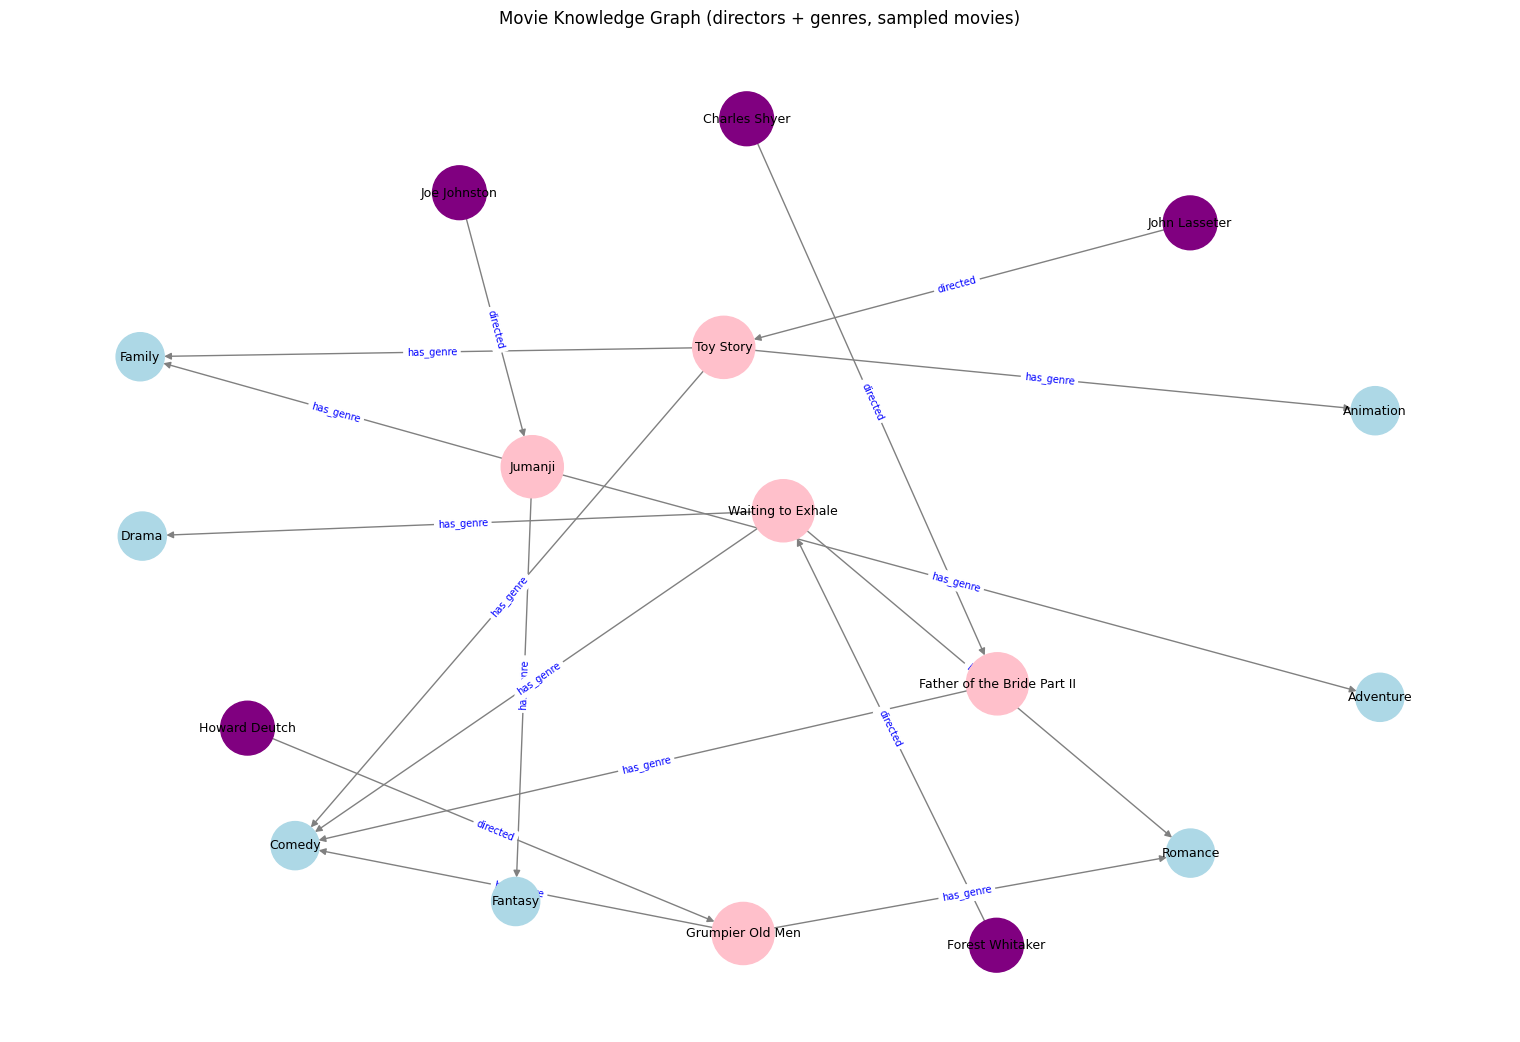

In [12]:
#Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_sub, seed=42, k=1.5) #k is the distance between nodes
nx.draw(G_sub, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, font_size=9, edge_color='gray')

edge_labels = nx.get_edge_attributes(G_sub, 'label')
nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_color='blue', font_size=7)

plt.title("Movie Knowledge Graph (directors + genres, sampled movies)")
plt.axis('off')
plt.show()